In [1]:
!which conda

/home/soumil/anaconda3/condabin/conda


In [2]:
import pandas as pd
import numpy as np
import os,cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model

from keras.initializers import *

2022-10-22 11:59:21.890524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 11:59:22.495186: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-22 11:59:23.440884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/soumil/anaconda3/envs/tf/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/home/soumil/root/lib
2022-10-22 11:59:23.440975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] C

# Visualisation of dataset

To get a feel of the data, exploratory data analysis is done.

The total number of train images from each subdirectory are stored and used in the bar and pie charts

In [3]:
datasets = ["./data/plant-seedlings-classification/train"]

class_names = ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

nb_classes = len(class_names)
class_name_labels

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

Loading the train data into 2 lists *images* and *labels*, each storing the image and its corresponding labels. The labels in this case are the type of seedlings as recorded in the dataset.

In [4]:
from tqdm import tqdm

def load_data():
    images,labels = [],[]
    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(os.path.join(dataset,folder),file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img,(150,150))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)
        
        pass
    
    return images,labels
    pass

In [5]:
(train_images),(train_labels) = load_data()

100%|████████████████████████████████████████| 516/516 [00:01<00:00, 315.94it/s]


Counting the number of images associated with each label.

In [6]:
n_train = train_labels.shape[0]

_, train_count = np.unique(train_labels,return_counts=True)

df = pd.DataFrame(data = train_count)
# df = df.T
df['Index'] = class_names
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


Creating a bar chart of train data using pandas *bar* function.

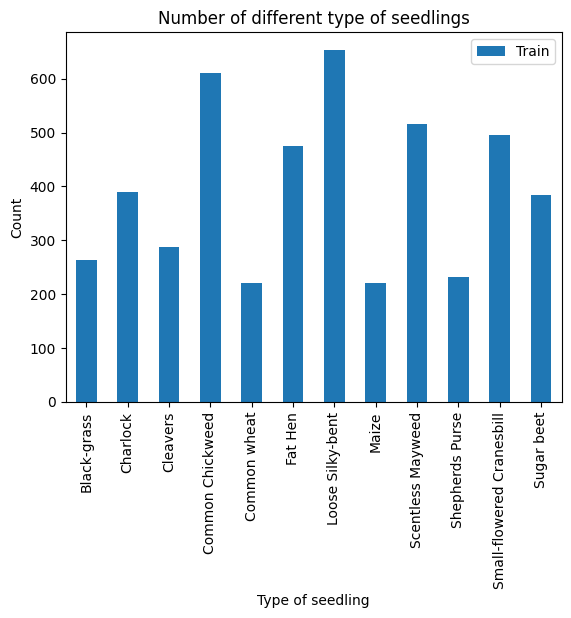

In [7]:
df.set_index("Name").plot.bar()
plt.xlabel("Type of seedling")
plt.ylabel("Count")
plt.title("Number of different type of seedlings");

As can be seen from the above bar chart that the maximum number of images belong to the class *Loose Silky-bent*, whatever that is. There is class imbalance with 5 classes having really low number of images while 2 classes have a high number of images with the rest around the median. 

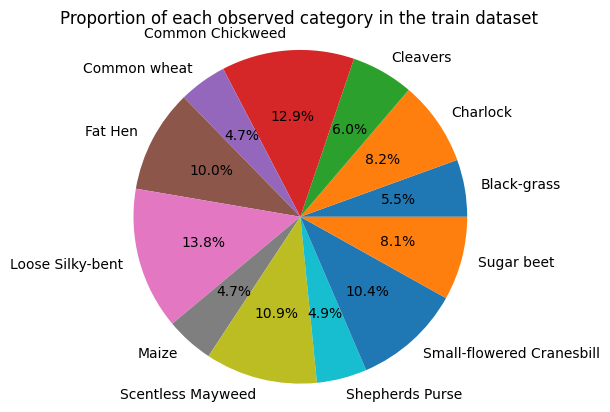

In [8]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0,0,0,0,0,0,0),
       labels = class_names,
       autopct = "%1.1f%%")
plt.axis('equal')
plt.title("Proportion of each observed category in the train dataset")
plt.show();

The class imbalance can also be inferred from the above pie chart, but this shows that it is not as steep as compared to the bar chart. It is advisable to normalize the count to give a better representation of the data present.

Creating a helper function for displaying the loss and accuracy versus epochs

In [9]:
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history["loss"],label="Loss")
    ax[0].plot(history.history["val_loss"],label="Test Loss")
    ax[1].plot(history.history["accuracy"],label="Accuracy")
    ax[1].plot(history.history["val_accuracy"],label="Test Accuracy")
    
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")

# Loading and Splitting Train Images

ImageDataGenerator from Keras is used for making the train dataset. Fora augmentation of images horizontal and vertical flip along with random rotation is used due to the low number of training images.

In [10]:
train_labels

array([0., 0., 0., ..., 8., 8., 8.], dtype=float32)

In [11]:
train_labels = to_categorical(train_labels,num_classes=nb_classes)

In [12]:
train_labels.shape

(4750, 12)

In [13]:
X_train,X_val,y_train,y_val = train_test_split(train_images,train_labels,test_size=0.3)

In [14]:
train_dir = "./data/plant-seedlings-classification/train"

batch_size = 16

IGD = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range=20)
#                         validation_split=0.3)

train_generator = IGD.flow(x=X_train,
                          y=y_train,
                          batch_size=batch_size,
                          shuffle=True,
                          seed=42)
#                           subset="training")

validation_generator = IGD.flow(x=X_val,
                               y=y_val,
                               batch_size=batch_size,
                               shuffle=True,
                               seed=42)
#                                subset="validation")

# Convolutional Block

Creating a Convolutional block for the model to make it easier to add more layers to the model without making major changes. This also allows for change in architecture without changing every line in the model. It also takes advantage of Python's OOP structure.

The block consists of:

`One convolutional layer with the user specifed filter size,kernel size, and lenght of strides.`
`One BatchNormalization Layer.`
`One Relu Activation Layer`

In [15]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'res_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + "_branch"
    
    F1 = filters
    
    X = Conv2D(filters=F1,kernel_size=(k,k),strides=(s,s),
              padding='same',name=conv_base_name,
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name)(X)
#     X = MaxPooling2D((3,3))(X)
    X = Activation('relu')(X)
    
    return X
    pass

# Creating the model

The current model consists of 4 convolutional layers and one fully connected layer, divided into various stages.

`Stage 1: Taking the input with kernel size = (5,5) and number of filters = 32.`
`Stage 2: Consists of 1 convolutional layer with a Relu activation and BatchNormalization.`
`Stage 3: Consists of 1 convolutional layer with a Relu activation and BatchNormalization.`
`Stage 4: Consists of 1 convolutional layer with a Relu activation and BatchNormalization.`

In [16]:
def conv_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(64,(5,5),strides=(2,2),name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
#     X = MaxPooling2D((3,3))(X)
#     X = Activation('relu')(X)
#     X = Dropout(0.1)(X)
    
    # Stage 2
    X = conv_block(X,5,64,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.1)(X)
    
    # Stage 3 
    X = conv_block(X,3,128,3,block='A',s=1)
    X = MaxPooling2D((3,3))(X)
    X = Dropout(0.1)(X)
    
    # Stage 4
    X = conv_block(X,5,256,4,block='A',s=1)
    X = MaxPooling2D((3,3))(X)
    X = Dropout(0.1)(X)
    
    # Stage 5
    X = conv_block(X,7,512,5,block='A',s=1)
    X = MaxPooling2D((3,3))(X)
    X = Dropout(0.1)(X)
    
    
    # Output Layer
    X = Flatten()(X)
    X = Dense(256)(X)
    X = Dense(256)(X)
    X = Dense(256)(X)
    X = Dense(256)(X)
    X = Activation('relu')(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='CNN')
    
    return model
    pass

In [17]:
model = conv_model(input_shape=(150,150,3),classes=nb_classes)

2022-10-22 12:00:04.340754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 12:00:04.515457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 12:00:04.516225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 12:00:04.518454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Saving the model architecture as a flowchart for better understanding to *`conv_model.png`*

In [18]:
plot_model(model,to_file='conv_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 73, 73, 64)        4864      
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 73, 73, 64)       256       
 n)                                                              
                                                                 
 res_2A_branch (Conv2D)      (None, 73, 73, 64)        102464    
                                                                 
 bn_2A_branch (BatchNormaliz  (None, 73, 73, 64)       256       
 ation)                                                          
                                                                 
 activation (Activation)     (None, 73, 73, 64)        0       

Using the Adam optimiser with learning rate set at 0.001 as this is currently giving the most optimal model.

In [19]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

/home/soumil/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Storing the model's weights to *`model_weights.h5`*. This stores the best weights possible.

In [20]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,
                             save_best_only=True,mode="max")
callbacks_list = [checkpoint]

Running the model for 50 epochs

In [36]:
epochs = 500

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.n//batch_size,
                              callbacks=callbacks_list,
                              verbose=1)

Epoch 1/500


/home/soumil/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == "__main__":


207/207 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.8643
Epoch 1: val_accuracy improved from 0.76404 to 0.81601, saving model to model_weights.h5
207/207 [==============================] - 16s 78ms/step - loss: 0.3820 - accuracy: 0.8643 - val_loss: 0.5153 - val_accuracy: 0.8160
Epoch 2/500
207/207 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8667
Epoch 2: val_accuracy improved from 0.81601 to 0.84199, saving model to model_weights.h5
207/207 [==============================] - 16s 77ms/step - loss: 0.3570 - accuracy: 0.8667 - val_loss: 0.4357 - val_accuracy: 0.8420
Epoch 3/500
207/207 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8719
Epoch 3: val_accuracy did not improve from 0.84199
207/207 [==============================] - 16s 76ms/step - loss: 0.3451 - accuracy: 0.8719 - val_loss: 0.5783 - val_accuracy: 0.7914
Epoch 4/500
207/207 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8

Epoch 58/500
207/207 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9553
Epoch 58: val_accuracy did not improve from 0.92416
207/207 [==============================] - 17s 82ms/step - loss: 0.1223 - accuracy: 0.9553 - val_loss: 0.2942 - val_accuracy: 0.9087
Epoch 59/500
207/207 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9662
Epoch 59: val_accuracy did not improve from 0.92416
207/207 [==============================] - 17s 82ms/step - loss: 0.0905 - accuracy: 0.9662 - val_loss: 0.3828 - val_accuracy: 0.8729
Epoch 60/500
207/207 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9659
Epoch 60: val_accuracy did not improve from 0.92416
207/207 [==============================] - 17s 83ms/step - loss: 0.0900 - accuracy: 0.9659 - val_loss: 0.2296 - val_accuracy: 0.9228
Epoch 61/500
207/207 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9652
Epoch 61: val_accuracy did not improve from 0.92416
2

Epoch 87/500
207/207 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9819
Epoch 87: val_accuracy did not improve from 0.94101
207/207 [==============================] - 17s 82ms/step - loss: 0.0508 - accuracy: 0.9819 - val_loss: 0.3555 - val_accuracy: 0.8982
Epoch 88/500
207/207 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9819
Epoch 88: val_accuracy did not improve from 0.94101
207/207 [==============================] - 17s 81ms/step - loss: 0.0535 - accuracy: 0.9819 - val_loss: 0.3198 - val_accuracy: 0.9150
Epoch 89/500
207/207 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9607
Epoch 89: val_accuracy did not improve from 0.94101
207/207 [==============================] - 17s 82ms/step - loss: 0.1145 - accuracy: 0.9607 - val_loss: 0.4129 - val_accuracy: 0.8862
Epoch 90/500
207/207 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9665
Epoch 90: val_accuracy did not improve from 0.94101
2

Epoch 116/500
207/207 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9785
Epoch 116: val_accuracy did not improve from 0.94101
207/207 [==============================] - 17s 82ms/step - loss: 0.0637 - accuracy: 0.9785 - val_loss: 0.2343 - val_accuracy: 0.9333
Epoch 117/500
207/207 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9897
Epoch 117: val_accuracy improved from 0.94101 to 0.94171, saving model to model_weights.h5
207/207 [==============================] - 18s 85ms/step - loss: 0.0359 - accuracy: 0.9897 - val_loss: 0.2380 - val_accuracy: 0.9417
Epoch 118/500
207/207 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9852
Epoch 118: val_accuracy did not improve from 0.94171
207/207 [==============================] - 17s 83ms/step - loss: 0.0392 - accuracy: 0.9852 - val_loss: 0.4444 - val_accuracy: 0.8876
Epoch 119/500
207/207 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9810
Epoch 11

207/207 [==============================] - 18s 85ms/step - loss: 0.0413 - accuracy: 0.9840 - val_loss: 0.4042 - val_accuracy: 0.8926
Epoch 145/500
207/207 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9885
Epoch 145: val_accuracy did not improve from 0.94663
207/207 [==============================] - 17s 83ms/step - loss: 0.0366 - accuracy: 0.9885 - val_loss: 0.2609 - val_accuracy: 0.9284
Epoch 146/500
207/207 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9891
Epoch 146: val_accuracy did not improve from 0.94663
207/207 [==============================] - 17s 81ms/step - loss: 0.0309 - accuracy: 0.9891 - val_loss: 0.5062 - val_accuracy: 0.8954
Epoch 147/500
207/207 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9840
Epoch 147: val_accuracy did not improve from 0.94663
207/207 [==============================] - 17s 82ms/step - loss: 0.0449 - accuracy: 0.9840 - val_loss: 0.6274 - val_accuracy: 0.8638
Epoch 148/50

Epoch 202/500
207/207 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9903
Epoch 202: val_accuracy did not improve from 0.94663
207/207 [==============================] - 17s 82ms/step - loss: 0.0271 - accuracy: 0.9903 - val_loss: 0.3223 - val_accuracy: 0.9178
Epoch 203/500
207/207 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9934
Epoch 203: val_accuracy did not improve from 0.94663
207/207 [==============================] - 17s 83ms/step - loss: 0.0181 - accuracy: 0.9934 - val_loss: 0.2365 - val_accuracy: 0.9382
Epoch 204/500
207/207 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9891
Epoch 204: val_accuracy did not improve from 0.94663
207/207 [==============================] - 17s 82ms/step - loss: 0.0380 - accuracy: 0.9891 - val_loss: 0.4449 - val_accuracy: 0.8933
Epoch 205/500
207/207 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9924
Epoch 205: val_accuracy did not improve from 0

Epoch 231/500
207/207 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9952
Epoch 231: val_accuracy did not improve from 0.94663
207/207 [==============================] - 17s 82ms/step - loss: 0.0129 - accuracy: 0.9952 - val_loss: 0.2824 - val_accuracy: 0.9361
Epoch 232/500
207/207 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9955
Epoch 232: val_accuracy improved from 0.94663 to 0.94803, saving model to model_weights.h5
207/207 [==============================] - 17s 81ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.2317 - val_accuracy: 0.9480
Epoch 233/500
207/207 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9927
Epoch 233: val_accuracy did not improve from 0.94803
207/207 [==============================] - 17s 82ms/step - loss: 0.0187 - accuracy: 0.9927 - val_loss: 0.3499 - val_accuracy: 0.9305
Epoch 234/500
207/207 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9900
Epoch 23

Epoch 260/500
207/207 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9912
Epoch 260: val_accuracy did not improve from 0.94803
207/207 [==============================] - 17s 80ms/step - loss: 0.0239 - accuracy: 0.9912 - val_loss: 0.5751 - val_accuracy: 0.8631
Epoch 261/500
207/207 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9927
Epoch 261: val_accuracy did not improve from 0.94803
207/207 [==============================] - 16s 79ms/step - loss: 0.0256 - accuracy: 0.9927 - val_loss: 0.2685 - val_accuracy: 0.9410
Epoch 262/500
207/207 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9927
Epoch 262: val_accuracy did not improve from 0.94803
207/207 [==============================] - 17s 81ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.2914 - val_accuracy: 0.9291
Epoch 263/500
207/207 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9930
Epoch 263: val_accuracy did not improve from 0

Epoch 317/500
207/207 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9955
Epoch 317: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 82ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.2759 - val_accuracy: 0.9305
Epoch 318/500
207/207 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9952
Epoch 318: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 80ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.2957 - val_accuracy: 0.9326
Epoch 319/500
207/207 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9949
Epoch 319: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 80ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.4152 - val_accuracy: 0.9094
Epoch 320/500
207/207 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9949
Epoch 320: val_accuracy did not improve from 0

Epoch 346/500
207/207 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9909
Epoch 346: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 80ms/step - loss: 0.0230 - accuracy: 0.9909 - val_loss: 0.6147 - val_accuracy: 0.8764
Epoch 347/500
207/207 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9934
Epoch 347: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 80ms/step - loss: 0.0238 - accuracy: 0.9934 - val_loss: 0.3140 - val_accuracy: 0.9242
Epoch 348/500
207/207 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9955
Epoch 348: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 80ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.2757 - val_accuracy: 0.9466
Epoch 349/500
207/207 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9958
Epoch 349: val_accuracy did not improve from 0

Epoch 375/500
207/207 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9985
Epoch 375: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 80ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.2632 - val_accuracy: 0.9480
Epoch 376/500
207/207 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9940
Epoch 376: val_accuracy did not improve from 0.95295
207/207 [==============================] - 16s 79ms/step - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.2647 - val_accuracy: 0.9473
Epoch 377/500
207/207 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9940
Epoch 377: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 82ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.2810 - val_accuracy: 0.9438
Epoch 378/500
207/207 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9961
Epoch 378: val_accuracy did not improve from 0

Epoch 404/500
207/207 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9949
Epoch 404: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 80ms/step - loss: 0.0127 - accuracy: 0.9949 - val_loss: 0.3692 - val_accuracy: 0.9277
Epoch 405/500
207/207 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000
Epoch 405: val_accuracy did not improve from 0.95295
207/207 [==============================] - 16s 79ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2798 - val_accuracy: 0.9438
Epoch 406/500
206/207 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9985
Epoch 406: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 81ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.3080 - val_accuracy: 0.9452
Epoch 407/500
207/207 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9970
Epoch 407: val_accuracy did not improve from 0

Epoch 433/500
207/207 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9961
Epoch 433: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 81ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.3423 - val_accuracy: 0.9417
Epoch 434/500
207/207 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9970
Epoch 434: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 81ms/step - loss: 0.0084 - accuracy: 0.9970 - val_loss: 0.2809 - val_accuracy: 0.9459
Epoch 435/500
207/207 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9946
Epoch 435: val_accuracy did not improve from 0.95295
207/207 [==============================] - 17s 80ms/step - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.4763 - val_accuracy: 0.9122
Epoch 436/500
207/207 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9958
Epoch 436: val_accuracy did not improve from 0

Epoch 462/500
207/207 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9934
Epoch 462: val_accuracy did not improve from 0.95576
207/207 [==============================] - 17s 81ms/step - loss: 0.0254 - accuracy: 0.9934 - val_loss: 0.3865 - val_accuracy: 0.9277
Epoch 463/500
207/207 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9967
Epoch 463: val_accuracy did not improve from 0.95576
207/207 [==============================] - 17s 82ms/step - loss: 0.0138 - accuracy: 0.9967 - val_loss: 0.3869 - val_accuracy: 0.9242
Epoch 464/500
207/207 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9955
Epoch 464: val_accuracy did not improve from 0.95576
207/207 [==============================] - 17s 83ms/step - loss: 0.0128 - accuracy: 0.9955 - val_loss: 0.4135 - val_accuracy: 0.9164
Epoch 465/500
207/207 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9912
Epoch 465: val_accuracy did not improve from 0

Epoch 491/500
207/207 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9952
Epoch 491: val_accuracy did not improve from 0.95576
207/207 [==============================] - 19s 90ms/step - loss: 0.0169 - accuracy: 0.9952 - val_loss: 0.2695 - val_accuracy: 0.9438
Epoch 492/500
207/207 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9927
Epoch 492: val_accuracy did not improve from 0.95576
207/207 [==============================] - 19s 91ms/step - loss: 0.0319 - accuracy: 0.9927 - val_loss: 0.2923 - val_accuracy: 0.9410
Epoch 493/500
207/207 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9970
Epoch 493: val_accuracy did not improve from 0.95576
207/207 [==============================] - 19s 90ms/step - loss: 0.0071 - accuracy: 0.9970 - val_loss: 0.4290 - val_accuracy: 0.9263
Epoch 494/500
207/207 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9930
Epoch 494: val_accuracy did not improve from 0

# Visualising the Loss and Accuracy of Model

Displaying the loss and accuracy versus epochs graph.

This graph allows the user to see whether the model needs to run for some more epochs or not.

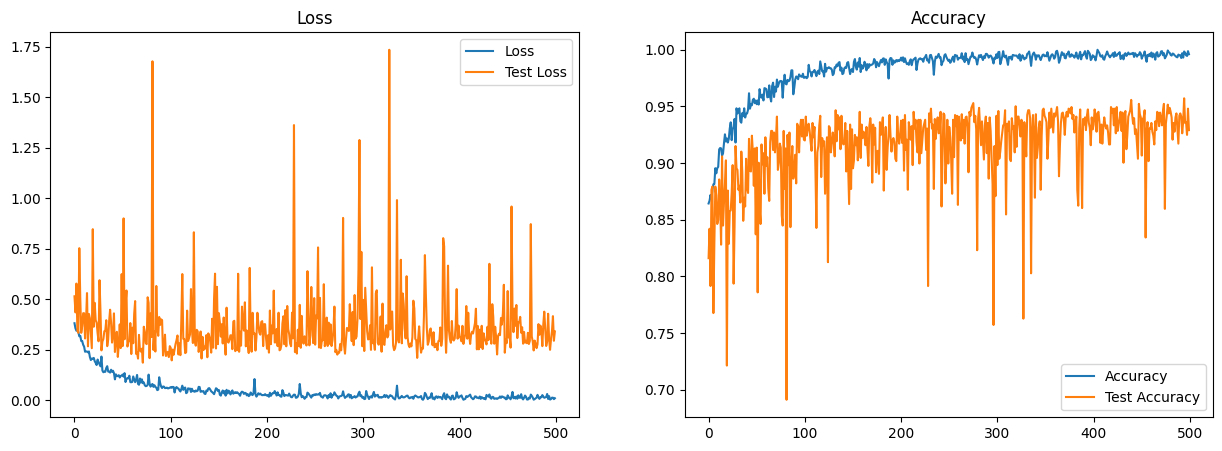

In [37]:
show_final_history(history)

The model is yet to reach the global minimum yet. At least the model is not overfitting which is a good thing. But its too bumpy, may need to change the momentum and learning rate for the optimizer.

# Plotting a Confusion Matrix

A confusion matrix is plotted below to see how well the model fared with respect to the train dataset. It will allow one to realize towards which class is the model biased against.

A threshold is set at half of the maximum correlation. Above that values are shown in white while below that are shown in black.

Bluer the shade of the block stronger the correlation between the predicted value and actual value. This type of matrix can also be shown for train data to show how the model fared there.

The model can be changed using this confusion matrix as a base calculation.

In [23]:
class_name_labels

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [24]:
y_test = np.argmax(y_val,axis=1)
y_test.shape,validation_generator.n

((1425,), 1425)

In [25]:
val_pred = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in val_pred]

/home/soumil/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [26]:
y_pred = np.argmax(val_pred,axis=1)
y_pred.shape

(1425,)

<Figure size 640x480 with 0 Axes>

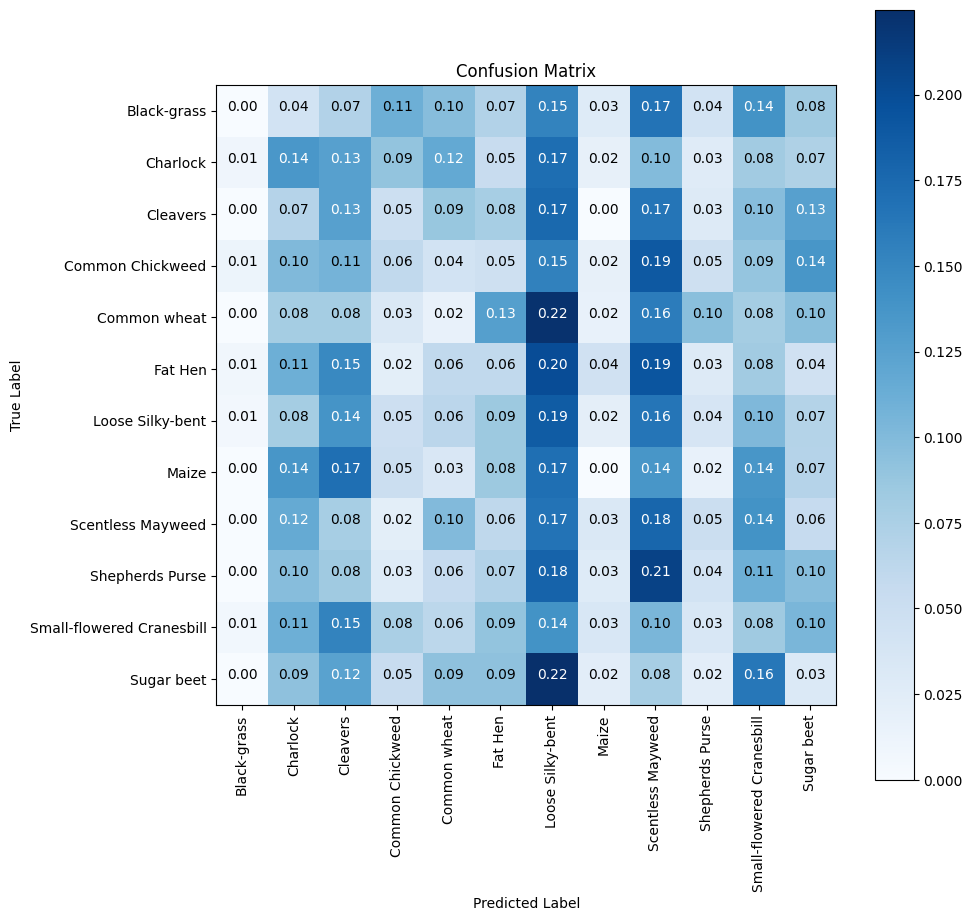

In [27]:
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.show()

The model is biased towards *Loose Silky Bent*

# Predicting the Test Images and making a submission

The test images are preprocessed via ImageDataGenerator and passed to the predict_generator function of the model for prediction. 

In [28]:
test_dir = ["./data/plant-seedlings-classification/test"]

def load_test():
    
    images,names = [],[]
    for dataset in test_dir:

        for file in tqdm(os.listdir(dataset)):
            
            img_path = os.path.join(dataset,file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))

            images.append(img)
            names.append(file)
            pass
        
        images = np.array(images,dtype=np.float32)
        pass
    
    return images,names
    pass

In [29]:
(test_images),(test_names) = load_test()

100%|████████████████████████████████████████| 794/794 [00:02<00:00, 363.85it/s]


In [30]:
for (label),(i) in class_name_labels.items():
    print(label,i)

Black-grass 0
Charlock 1
Cleavers 2
Common Chickweed 3
Common wheat 4
Fat Hen 5
Loose Silky-bent 6
Maize 7
Scentless Mayweed 8
Shepherds Purse 9
Small-flowered Cranesbill 10
Sugar beet 11


In [31]:
test_images[0].shape

(150, 150, 3)

In [32]:
from tensorflow.keras.utils import img_to_array

predicted_class = []
class_labels = dict((i,label) for label,i in class_name_labels.items())
for image in tqdm(test_images):
    
    image = np.expand_dims(image, axis=0)
    test_result = model.predict(image)
    pred_class = np.argmax(test_result,axis=1)
    prediction = [class_labels[k] for k in pred_class][0]
    predicted_class.append(prediction)
    pass

results = pd.DataFrame({"file":test_names,
                        "species":predicted_class})

  0%|                                                   | 0/794 [00:00<?, ?it/s]

1/1 [==============================] - 0s 128ms/step


  0%|                                           | 1/794 [00:00<02:17,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏                                          | 4/794 [00:00<00:57, 13.65it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▎                                          | 6/794 [00:00<00:51, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▍                                          | 9/794 [00:00<00:45, 17.22it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▋                                         | 12/794 [00:00<00:43, 18.02it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                         | 15/794 [00:00<00:40, 19.12it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▉                                         | 17/794 [00:00<00:40, 19.07it/s]

1/1 [==============================] - 0s 15ms/step


  2%|█                                         | 19/794 [00:01<00:40, 19.19it/s]

1/1 [==============================] - 0s 20ms/step


  3%|█                                         | 21/794 [00:01<00:42, 18.36it/s]

1/1 [==============================] - 0s 22ms/step


  3%|█▏                                        | 23/794 [00:01<00:43, 17.88it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▎                                        | 25/794 [00:01<00:42, 17.97it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▍                                        | 28/794 [00:01<00:40, 18.72it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▋                                        | 31/794 [00:01<00:39, 19.22it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▋                                        | 33/794 [00:01<00:40, 19.02it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▊                                        | 35/794 [00:01<00:39, 19.25it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                        | 38/794 [00:02<00:38, 19.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|██                                        | 40/794 [00:02<00:38, 19.81it/s]

1/1 [==============================] - 0s 17ms/step


  5%|██▏                                       | 42/794 [00:02<00:38, 19.58it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██▎                                       | 44/794 [00:02<00:38, 19.66it/s]

1/1 [==============================] - 0s 18ms/step


  6%|██▍                                       | 46/794 [00:02<00:38, 19.35it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██▌                                       | 49/794 [00:02<00:37, 19.70it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██▋                                       | 51/794 [00:02<00:38, 19.33it/s]

1/1 [==============================] - 0s 18ms/step


  7%|██▊                                       | 53/794 [00:02<00:38, 19.39it/s]

1/1 [==============================] - 0s 17ms/step


  7%|██▉                                       | 55/794 [00:02<00:37, 19.45it/s]

1/1 [==============================] - 0s 18ms/step


  7%|███                                       | 57/794 [00:03<00:37, 19.48it/s]

1/1 [==============================] - 0s 17ms/step


  8%|███▏                                      | 60/794 [00:03<00:37, 19.80it/s]

1/1 [==============================] - 0s 17ms/step


  8%|███▎                                      | 63/794 [00:03<00:36, 19.90it/s]

1/1 [==============================] - 0s 19ms/step


  8%|███▍                                      | 65/794 [00:03<00:38, 19.00it/s]

1/1 [==============================] - 0s 20ms/step


  8%|███▌                                      | 67/794 [00:03<00:39, 18.54it/s]

1/1 [==============================] - 0s 19ms/step


  9%|███▋                                      | 69/794 [00:03<00:39, 18.29it/s]

1/1 [==============================] - 0s 19ms/step


  9%|███▊                                      | 71/794 [00:03<00:40, 17.99it/s]

1/1 [==============================] - 0s 19ms/step


  9%|███▊                                      | 73/794 [00:03<00:39, 18.23it/s]

1/1 [==============================] - 0s 18ms/step


  9%|███▉                                      | 75/794 [00:04<00:38, 18.62it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████▏                                     | 78/794 [00:04<00:36, 19.76it/s]

1/1 [==============================] - 0s 18ms/step


 10%|████▎                                     | 81/794 [00:04<00:35, 20.37it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▍                                     | 84/794 [00:04<00:34, 20.57it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████▌                                     | 87/794 [00:04<00:35, 19.75it/s]

1/1 [==============================] - 0s 20ms/step


 11%|████▋                                     | 89/794 [00:04<00:36, 19.29it/s]

1/1 [==============================] - 0s 19ms/step


 11%|████▊                                     | 91/794 [00:04<00:36, 19.23it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                     | 93/794 [00:04<00:36, 19.34it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█████                                     | 96/794 [00:05<00:35, 19.78it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█████▏                                    | 98/794 [00:05<00:36, 19.31it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█████▏                                   | 100/794 [00:05<00:36, 18.91it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                   | 102/794 [00:05<00:36, 18.80it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                   | 104/794 [00:05<00:37, 18.61it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▌                                   | 107/794 [00:05<00:35, 19.18it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█████▋                                   | 110/794 [00:05<00:34, 19.78it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▊                                   | 113/794 [00:05<00:33, 20.27it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                   | 116/794 [00:06<00:32, 20.56it/s]

1/1 [==============================] - 0s 15ms/step


 15%|██████▏                                  | 119/794 [00:06<00:31, 21.14it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████▎                                  | 122/794 [00:06<00:31, 21.35it/s]

1/1 [==============================] - 0s 18ms/step


 16%|██████▍                                  | 125/794 [00:06<00:32, 20.84it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▌                                  | 128/794 [00:06<00:31, 21.16it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▊                                  | 131/794 [00:06<00:30, 21.40it/s]

1/1 [==============================] - 0s 20ms/step


 17%|██████▉                                  | 134/794 [00:06<00:32, 20.47it/s]

1/1 [==============================] - 0s 16ms/step


 17%|███████                                  | 137/794 [00:07<00:32, 20.46it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▏                                 | 140/794 [00:07<00:31, 20.94it/s]

1/1 [==============================] - 0s 15ms/step


 18%|███████▍                                 | 143/794 [00:07<00:31, 20.68it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▌                                 | 146/794 [00:07<00:30, 21.19it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████▋                                 | 149/794 [00:07<00:29, 21.56it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▊                                 | 152/794 [00:07<00:29, 21.64it/s]

1/1 [==============================] - 0s 15ms/step


 20%|████████                                 | 155/794 [00:07<00:29, 21.77it/s]

1/1 [==============================] - 0s 16ms/step


 20%|████████▏                                | 158/794 [00:08<00:28, 22.10it/s]

1/1 [==============================] - 0s 15ms/step


 20%|████████▎                                | 161/794 [00:08<00:28, 22.18it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▍                                | 164/794 [00:08<00:29, 21.68it/s]

1/1 [==============================] - 0s 18ms/step


 21%|████████▌                                | 167/794 [00:08<00:29, 21.08it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▊                                | 170/794 [00:08<00:30, 20.63it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▉                                | 173/794 [00:08<00:29, 20.86it/s]

1/1 [==============================] - 0s 19ms/step


 22%|█████████                                | 176/794 [00:08<00:29, 20.73it/s]

1/1 [==============================] - 0s 22ms/step


 23%|█████████▏                               | 179/794 [00:09<00:31, 19.84it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████▎                               | 181/794 [00:09<00:32, 18.83it/s]

1/1 [==============================] - 0s 15ms/step


 23%|█████████▌                               | 184/794 [00:09<00:31, 19.43it/s]

1/1 [==============================] - 0s 15ms/step


 24%|█████████▋                               | 187/794 [00:09<00:29, 20.36it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▊                               | 190/794 [00:09<00:28, 20.93it/s]

1/1 [==============================] - 0s 18ms/step


 24%|█████████▉                               | 193/794 [00:09<00:29, 20.21it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██████████                               | 196/794 [00:09<00:29, 20.18it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██████████▎                              | 199/794 [00:10<00:28, 20.70it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██████████▍                              | 202/794 [00:10<00:28, 20.93it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██████████▌                              | 205/794 [00:10<00:29, 20.11it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▋                              | 208/794 [00:10<00:29, 20.19it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▉                              | 211/794 [00:10<00:27, 20.84it/s]

1/1 [==============================] - 0s 17ms/step


 27%|███████████                              | 214/794 [00:10<00:27, 20.81it/s]

1/1 [==============================] - 0s 20ms/step


 27%|███████████▏                             | 217/794 [00:10<00:28, 20.17it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████▎                             | 220/794 [00:11<00:28, 19.88it/s]

1/1 [==============================] - 0s 15ms/step


 28%|███████████▌                             | 223/794 [00:11<00:27, 20.66it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████▋                             | 226/794 [00:11<00:26, 21.08it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▊                             | 229/794 [00:11<00:26, 21.03it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████▉                             | 232/794 [00:11<00:26, 20.90it/s]

1/1 [==============================] - 0s 16ms/step


 30%|████████████▏                            | 235/794 [00:11<00:26, 21.39it/s]

1/1 [==============================] - 0s 18ms/step


 30%|████████████▎                            | 238/794 [00:11<00:25, 21.59it/s]

1/1 [==============================] - 0s 19ms/step


 30%|████████████▍                            | 241/794 [00:12<00:26, 20.53it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████▌                            | 244/794 [00:12<00:27, 20.08it/s]

1/1 [==============================] - 0s 15ms/step


 31%|████████████▊                            | 247/794 [00:12<00:26, 20.56it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▉                            | 250/794 [00:12<00:26, 20.82it/s]

1/1 [==============================] - 0s 16ms/step


 32%|█████████████                            | 253/794 [00:12<00:26, 20.80it/s]

1/1 [==============================] - 0s 16ms/step


 32%|█████████████▏                           | 256/794 [00:12<00:25, 21.08it/s]

1/1 [==============================] - 0s 15ms/step


 33%|█████████████▎                           | 259/794 [00:12<00:25, 21.29it/s]

1/1 [==============================] - 0s 15ms/step


 33%|█████████████▌                           | 262/794 [00:13<00:24, 21.68it/s]

1/1 [==============================] - 0s 19ms/step


 33%|█████████████▋                           | 265/794 [00:13<00:24, 21.41it/s]

1/1 [==============================] - 0s 18ms/step


 34%|█████████████▊                           | 268/794 [00:13<00:25, 20.95it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▉                           | 271/794 [00:13<00:24, 20.92it/s]

1/1 [==============================] - 0s 15ms/step


 35%|██████████████▏                          | 274/794 [00:13<00:24, 21.45it/s]

1/1 [==============================] - 0s 16ms/step


 35%|██████████████▎                          | 277/794 [00:13<00:23, 21.63it/s]

1/1 [==============================] - 0s 20ms/step


 35%|██████████████▍                          | 280/794 [00:13<00:25, 20.41it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▌                          | 283/794 [00:14<00:24, 20.72it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▊                          | 286/794 [00:14<00:24, 21.02it/s]

1/1 [==============================] - 0s 18ms/step


 36%|██████████████▉                          | 289/794 [00:14<00:24, 20.92it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███████████████                          | 292/794 [00:14<00:23, 21.02it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███████████████▏                         | 295/794 [00:14<00:23, 21.47it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███████████████▍                         | 298/794 [00:14<00:23, 21.53it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███████████████▌                         | 301/794 [00:14<00:23, 21.11it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███████████████▋                         | 304/794 [00:15<00:23, 21.00it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███████████████▊                         | 307/794 [00:15<00:22, 21.53it/s]

1/1 [==============================] - 0s 16ms/step


 39%|████████████████                         | 310/794 [00:15<00:22, 21.49it/s]

1/1 [==============================] - 0s 19ms/step


 39%|████████████████▏                        | 313/794 [00:15<00:22, 21.10it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████████████████▎                        | 316/794 [00:15<00:23, 20.65it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████████████████▍                        | 319/794 [00:15<00:23, 20.55it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████████████████▋                        | 322/794 [00:15<00:22, 21.21it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████████████████▊                        | 325/794 [00:16<00:21, 21.46it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████▉                        | 328/794 [00:16<00:22, 21.00it/s]

1/1 [==============================] - 0s 15ms/step


 42%|█████████████████                        | 331/794 [00:16<00:21, 21.10it/s]

1/1 [==============================] - 0s 16ms/step


 42%|█████████████████▏                       | 334/794 [00:16<00:21, 21.62it/s]

1/1 [==============================] - 0s 16ms/step


 42%|█████████████████▍                       | 337/794 [00:16<00:21, 21.51it/s]

1/1 [==============================] - 0s 17ms/step


 43%|█████████████████▌                       | 340/794 [00:16<00:21, 21.45it/s]

1/1 [==============================] - 0s 17ms/step


 43%|█████████████████▋                       | 343/794 [00:16<00:21, 20.92it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▊                       | 346/794 [00:17<00:21, 21.27it/s]

1/1 [==============================] - 0s 16ms/step


 44%|██████████████████                       | 349/794 [00:17<00:21, 21.14it/s]

1/1 [==============================] - 0s 17ms/step


 44%|██████████████████▏                      | 352/794 [00:17<00:21, 21.03it/s]

1/1 [==============================] - 0s 19ms/step


 45%|██████████████████▎                      | 355/794 [00:17<00:21, 20.85it/s]

1/1 [==============================] - 0s 16ms/step


 45%|██████████████████▍                      | 358/794 [00:17<00:21, 20.64it/s]

1/1 [==============================] - 0s 16ms/step


 45%|██████████████████▋                      | 361/794 [00:17<00:20, 21.22it/s]

1/1 [==============================] - 0s 18ms/step


 46%|██████████████████▊                      | 364/794 [00:17<00:20, 21.44it/s]

1/1 [==============================] - 0s 20ms/step


 46%|██████████████████▉                      | 367/794 [00:18<00:20, 20.59it/s]

1/1 [==============================] - 0s 16ms/step


 47%|███████████████████                      | 370/794 [00:18<00:20, 20.52it/s]

1/1 [==============================] - 0s 17ms/step


 47%|███████████████████▎                     | 373/794 [00:18<00:20, 20.81it/s]

1/1 [==============================] - 0s 16ms/step


 47%|███████████████████▍                     | 376/794 [00:18<00:19, 20.90it/s]

1/1 [==============================] - 0s 21ms/step


 48%|███████████████████▌                     | 379/794 [00:18<00:20, 20.01it/s]

1/1 [==============================] - 0s 17ms/step


 48%|███████████████████▋                     | 382/794 [00:18<00:20, 19.88it/s]

1/1 [==============================] - 0s 16ms/step


 48%|███████████████████▉                     | 385/794 [00:18<00:20, 20.25it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████████████████████                     | 388/794 [00:19<00:19, 20.89it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████████████████████▏                    | 391/794 [00:19<00:19, 20.94it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████████████████████▎                    | 394/794 [00:19<00:19, 20.27it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████████████████████▌                    | 397/794 [00:19<00:19, 20.53it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████████████████████▋                    | 400/794 [00:19<00:18, 20.89it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████▊                    | 403/794 [00:19<00:19, 20.47it/s]

1/1 [==============================] - 0s 16ms/step


 51%|████████████████████▉                    | 406/794 [00:19<00:19, 19.87it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████████████████████                    | 409/794 [00:20<00:18, 20.51it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████████████████████▎                   | 412/794 [00:20<00:18, 21.05it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████████████████████▍                   | 415/794 [00:20<00:18, 20.73it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████████████████████▌                   | 418/794 [00:20<00:18, 20.06it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████████████████████▋                   | 421/794 [00:20<00:18, 20.60it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████████████████████▉                   | 424/794 [00:20<00:18, 20.29it/s]

1/1 [==============================] - 0s 19ms/step


 54%|██████████████████████                   | 427/794 [00:21<00:18, 19.86it/s]

1/1 [==============================] - 0s 16ms/step


 54%|██████████████████████▏                  | 429/794 [00:21<00:18, 19.86it/s]

1/1 [==============================] - 0s 15ms/step


 54%|██████████████████████▎                  | 432/794 [00:21<00:17, 20.40it/s]

1/1 [==============================] - 0s 16ms/step


 55%|██████████████████████▍                  | 435/794 [00:21<00:17, 20.63it/s]

1/1 [==============================] - 0s 20ms/step


 55%|██████████████████████▌                  | 438/794 [00:21<00:17, 19.92it/s]

1/1 [==============================] - 0s 17ms/step


 56%|██████████████████████▊                  | 441/794 [00:21<00:17, 19.83it/s]

1/1 [==============================] - 0s 19ms/step


 56%|██████████████████████▉                  | 444/794 [00:21<00:17, 19.87it/s]

1/1 [==============================] - 0s 18ms/step


 56%|███████████████████████                  | 446/794 [00:21<00:17, 19.59it/s]

1/1 [==============================] - 0s 16ms/step


 56%|███████████████████████▏                 | 448/794 [00:22<00:17, 19.58it/s]

1/1 [==============================] - 0s 16ms/step


 57%|███████████████████████▎                 | 451/794 [00:22<00:16, 20.26it/s]

1/1 [==============================] - 0s 16ms/step


 57%|███████████████████████▍                 | 454/794 [00:22<00:16, 20.01it/s]

1/1 [==============================] - 0s 18ms/step


 57%|███████████████████████▌                 | 456/794 [00:22<00:17, 19.53it/s]

1/1 [==============================] - 0s 19ms/step


 58%|███████████████████████▋                 | 458/794 [00:22<00:17, 19.53it/s]

1/1 [==============================] - 0s 17ms/step


 58%|███████████████████████▊                 | 460/794 [00:22<00:17, 19.40it/s]

1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████▉                 | 463/794 [00:22<00:16, 19.91it/s]

1/1 [==============================] - 0s 20ms/step


 59%|████████████████████████                 | 466/794 [00:22<00:16, 19.80it/s]

1/1 [==============================] - 0s 18ms/step


 59%|████████████████████████▏                | 468/794 [00:23<00:16, 19.35it/s]

1/1 [==============================] - 0s 18ms/step


 59%|████████████████████████▎                | 470/794 [00:23<00:16, 19.31it/s]

1/1 [==============================] - 0s 16ms/step


 60%|████████████████████████▍                | 473/794 [00:23<00:15, 20.11it/s]

1/1 [==============================] - 0s 16ms/step


 60%|████████████████████████▌                | 476/794 [00:23<00:15, 20.53it/s]

1/1 [==============================] - 0s 19ms/step


 60%|████████████████████████▋                | 479/794 [00:23<00:15, 20.64it/s]

1/1 [==============================] - 0s 19ms/step


 61%|████████████████████████▉                | 482/794 [00:23<00:15, 19.54it/s]

1/1 [==============================] - 0s 15ms/step


 61%|█████████████████████████                | 485/794 [00:23<00:15, 20.09it/s]

1/1 [==============================] - 0s 15ms/step


 61%|█████████████████████████▏               | 488/794 [00:24<00:14, 20.71it/s]

1/1 [==============================] - 0s 20ms/step


 62%|█████████████████████████▎               | 491/794 [00:24<00:15, 20.03it/s]

1/1 [==============================] - 0s 17ms/step


 62%|█████████████████████████▌               | 494/794 [00:24<00:14, 20.08it/s]

1/1 [==============================] - 0s 15ms/step


 63%|█████████████████████████▋               | 497/794 [00:24<00:14, 20.62it/s]

1/1 [==============================] - 0s 15ms/step


 63%|█████████████████████████▊               | 500/794 [00:24<00:13, 21.21it/s]

1/1 [==============================] - 0s 20ms/step


 63%|█████████████████████████▉               | 503/794 [00:24<00:14, 20.24it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████████████████████████▏              | 506/794 [00:24<00:14, 20.25it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████████████████████████▎              | 509/794 [00:25<00:13, 20.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████████████████████████▍              | 512/794 [00:25<00:13, 20.64it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████████████████████████▌              | 515/794 [00:25<00:13, 20.50it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████████████████████████▋              | 518/794 [00:25<00:13, 20.71it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████████████████████████▉              | 521/794 [00:25<00:13, 20.89it/s]

1/1 [==============================] - 0s 17ms/step


 66%|███████████████████████████              | 524/794 [00:25<00:12, 20.83it/s]

1/1 [==============================] - 0s 18ms/step


 66%|███████████████████████████▏             | 527/794 [00:25<00:13, 20.18it/s]

1/1 [==============================] - 0s 16ms/step


 67%|███████████████████████████▎             | 530/794 [00:26<00:12, 20.71it/s]

1/1 [==============================] - 0s 16ms/step


 67%|███████████████████████████▌             | 533/794 [00:26<00:12, 20.94it/s]

1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████▋             | 536/794 [00:26<00:12, 21.00it/s]

1/1 [==============================] - 0s 19ms/step


 68%|███████████████████████████▊             | 539/794 [00:26<00:12, 20.85it/s]

1/1 [==============================] - 0s 16ms/step


 68%|███████████████████████████▉             | 542/794 [00:26<00:12, 20.54it/s]

1/1 [==============================] - 0s 17ms/step


 69%|████████████████████████████▏            | 545/794 [00:26<00:12, 20.60it/s]

1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████▎            | 548/794 [00:26<00:12, 20.41it/s]

1/1 [==============================] - 0s 17ms/step


 69%|████████████████████████████▍            | 551/794 [00:27<00:12, 20.24it/s]

1/1 [==============================] - 0s 17ms/step


 70%|████████████████████████████▌            | 554/794 [00:27<00:11, 20.15it/s]

1/1 [==============================] - 0s 18ms/step


 70%|████████████████████████████▊            | 557/794 [00:27<00:11, 20.32it/s]

1/1 [==============================] - 0s 18ms/step


 71%|████████████████████████████▉            | 560/794 [00:27<00:11, 20.17it/s]

1/1 [==============================] - 0s 18ms/step


 71%|█████████████████████████████            | 563/794 [00:27<00:11, 19.93it/s]

1/1 [==============================] - 0s 16ms/step


 71%|█████████████████████████████▏           | 566/794 [00:27<00:11, 20.43it/s]

1/1 [==============================] - 0s 17ms/step


 72%|█████████████████████████████▍           | 569/794 [00:28<00:11, 20.41it/s]

1/1 [==============================] - 0s 17ms/step


 72%|█████████████████████████████▌           | 572/794 [00:28<00:10, 20.31it/s]

1/1 [==============================] - 0s 17ms/step


 72%|█████████████████████████████▋           | 575/794 [00:28<00:10, 20.44it/s]

1/1 [==============================] - 0s 15ms/step


 73%|█████████████████████████████▊           | 578/794 [00:28<00:10, 20.73it/s]

1/1 [==============================] - 0s 20ms/step


 73%|██████████████████████████████           | 581/794 [00:28<00:10, 20.08it/s]

1/1 [==============================] - 0s 17ms/step


 74%|██████████████████████████████▏          | 584/794 [00:28<00:10, 20.02it/s]

1/1 [==============================] - 0s 18ms/step


 74%|██████████████████████████████▎          | 587/794 [00:28<00:10, 20.10it/s]

1/1 [==============================] - 0s 16ms/step


 74%|██████████████████████████████▍          | 590/794 [00:29<00:10, 20.29it/s]

1/1 [==============================] - 0s 16ms/step


 75%|██████████████████████████████▌          | 593/794 [00:29<00:09, 20.64it/s]

1/1 [==============================] - 0s 17ms/step


 75%|██████████████████████████████▊          | 596/794 [00:29<00:09, 20.80it/s]

1/1 [==============================] - 0s 18ms/step


 75%|██████████████████████████████▉          | 599/794 [00:29<00:09, 20.18it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████████████████████████████          | 602/794 [00:29<00:09, 20.21it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████████████████████████████▏         | 605/794 [00:29<00:09, 20.29it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████████████████████████████▍         | 608/794 [00:29<00:09, 20.27it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████████████████████████████▌         | 611/794 [00:30<00:09, 20.29it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████████████████████████████▋         | 614/794 [00:30<00:08, 20.72it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████████████████████████████▊         | 617/794 [00:30<00:08, 20.99it/s]

1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████         | 620/794 [00:30<00:08, 20.49it/s]

1/1 [==============================] - 0s 16ms/step


 78%|████████████████████████████████▏        | 623/794 [00:30<00:08, 20.69it/s]

1/1 [==============================] - 0s 20ms/step


 79%|████████████████████████████████▎        | 626/794 [00:30<00:08, 20.21it/s]

1/1 [==============================] - 0s 19ms/step


 79%|████████████████████████████████▍        | 629/794 [00:30<00:08, 20.17it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████████████████████████████▋        | 632/794 [00:31<00:07, 20.30it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████████████████████████████▊        | 635/794 [00:31<00:07, 20.02it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████████████████████████████▉        | 638/794 [00:31<00:07, 20.30it/s]

1/1 [==============================] - 0s 17ms/step


 81%|█████████████████████████████████        | 641/794 [00:31<00:07, 20.58it/s]

1/1 [==============================] - 0s 15ms/step


 81%|█████████████████████████████████▎       | 644/794 [00:31<00:07, 20.96it/s]

1/1 [==============================] - 0s 15ms/step


 81%|█████████████████████████████████▍       | 647/794 [00:31<00:06, 21.30it/s]

1/1 [==============================] - 0s 15ms/step


 82%|█████████████████████████████████▌       | 650/794 [00:31<00:06, 21.08it/s]

1/1 [==============================] - 0s 17ms/step


 82%|█████████████████████████████████▋       | 653/794 [00:32<00:06, 21.25it/s]

1/1 [==============================] - 0s 16ms/step


 83%|█████████████████████████████████▊       | 656/794 [00:32<00:06, 21.23it/s]

1/1 [==============================] - 0s 17ms/step


 83%|██████████████████████████████████       | 659/794 [00:32<00:06, 20.91it/s]

1/1 [==============================] - 0s 18ms/step


 83%|██████████████████████████████████▏      | 662/794 [00:32<00:06, 20.73it/s]

1/1 [==============================] - 0s 17ms/step


 84%|██████████████████████████████████▎      | 665/794 [00:32<00:06, 20.91it/s]

1/1 [==============================] - 0s 17ms/step


 84%|██████████████████████████████████▍      | 668/794 [00:32<00:06, 20.26it/s]

1/1 [==============================] - 0s 15ms/step


 85%|██████████████████████████████████▋      | 671/794 [00:32<00:05, 20.54it/s]

1/1 [==============================] - 0s 16ms/step


 85%|██████████████████████████████████▊      | 674/794 [00:33<00:05, 20.94it/s]

1/1 [==============================] - 0s 17ms/step


 85%|██████████████████████████████████▉      | 677/794 [00:33<00:05, 20.55it/s]

1/1 [==============================] - 0s 17ms/step


 86%|███████████████████████████████████      | 680/794 [00:33<00:05, 20.54it/s]

1/1 [==============================] - 0s 16ms/step


 86%|███████████████████████████████████▎     | 683/794 [00:33<00:05, 20.68it/s]

1/1 [==============================] - 0s 16ms/step


 86%|███████████████████████████████████▍     | 686/794 [00:33<00:05, 20.78it/s]

1/1 [==============================] - 0s 16ms/step


 87%|███████████████████████████████████▌     | 689/794 [00:33<00:05, 20.48it/s]

1/1 [==============================] - 0s 15ms/step


 87%|███████████████████████████████████▋     | 692/794 [00:34<00:04, 20.82it/s]

1/1 [==============================] - 0s 18ms/step


 88%|███████████████████████████████████▉     | 695/794 [00:34<00:04, 20.84it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████████████████████████████████     | 698/794 [00:34<00:04, 20.25it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████▏    | 701/794 [00:34<00:04, 20.42it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████████████████████████████████▎    | 704/794 [00:34<00:04, 20.09it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████████████████████████████████▌    | 707/794 [00:34<00:04, 19.72it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████▋    | 710/794 [00:34<00:04, 20.30it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████████████████████████████████▊    | 713/794 [00:35<00:03, 20.56it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████████████████████████████████▉    | 716/794 [00:35<00:03, 20.25it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████████████████████████████████▏   | 719/794 [00:35<00:03, 20.60it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████████████████████████████████▎   | 722/794 [00:35<00:03, 20.66it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████████████████████████████████▍   | 725/794 [00:35<00:03, 20.59it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████████████████████████████████▌   | 728/794 [00:35<00:03, 20.63it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████████████████████████████████▋   | 731/794 [00:35<00:03, 20.80it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████████████████████████████████▉   | 734/794 [00:36<00:02, 20.85it/s]

1/1 [==============================] - 0s 17ms/step


 93%|██████████████████████████████████████   | 737/794 [00:36<00:02, 20.75it/s]

1/1 [==============================] - 0s 16ms/step


 93%|██████████████████████████████████████▏  | 740/794 [00:36<00:02, 21.04it/s]

1/1 [==============================] - 0s 16ms/step


 94%|██████████████████████████████████████▎  | 743/794 [00:36<00:02, 21.04it/s]

1/1 [==============================] - 0s 16ms/step


 94%|██████████████████████████████████████▌  | 746/794 [00:36<00:02, 20.85it/s]

1/1 [==============================] - 0s 16ms/step


 94%|██████████████████████████████████████▋  | 749/794 [00:36<00:02, 21.08it/s]

1/1 [==============================] - 0s 16ms/step


 95%|██████████████████████████████████████▊  | 752/794 [00:36<00:01, 21.36it/s]

1/1 [==============================] - 0s 17ms/step


 95%|██████████████████████████████████████▉  | 755/794 [00:37<00:01, 21.21it/s]

1/1 [==============================] - 0s 17ms/step


 95%|███████████████████████████████████████▏ | 758/794 [00:37<00:01, 21.25it/s]

1/1 [==============================] - 0s 18ms/step


 96%|███████████████████████████████████████▎ | 761/794 [00:37<00:01, 21.22it/s]

1/1 [==============================] - 0s 16ms/step


 96%|███████████████████████████████████████▍ | 764/794 [00:37<00:01, 21.38it/s]

1/1 [==============================] - 0s 19ms/step


 97%|███████████████████████████████████████▌ | 767/794 [00:37<00:01, 20.42it/s]

1/1 [==============================] - 0s 17ms/step


 97%|███████████████████████████████████████▊ | 770/794 [00:37<00:01, 20.34it/s]

1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████▉ | 773/794 [00:37<00:01, 20.56it/s]

1/1 [==============================] - 0s 17ms/step


 98%|████████████████████████████████████████ | 776/794 [00:38<00:00, 20.12it/s]

1/1 [==============================] - 0s 16ms/step


 98%|████████████████████████████████████████▏| 779/794 [00:38<00:00, 20.81it/s]

1/1 [==============================] - 0s 16ms/step


 98%|████████████████████████████████████████▍| 782/794 [00:38<00:00, 21.14it/s]

1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████▌| 785/794 [00:38<00:00, 21.18it/s]

1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████▋| 788/794 [00:38<00:00, 21.39it/s]

1/1 [==============================] - 0s 17ms/step


100%|████████████████████████████████████████▊| 791/794 [00:38<00:00, 21.38it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████████████████████████████████████| 794/794 [00:38<00:00, 20.40it/s]


In [33]:
results.head()

,file,species
0,647689543.png,Charlock
1,bea23d9f8.png,Maize
2,0086a6340.png,Maize
3,ac3193f78.png,Maize
4,b4c3df835.png,Maize


In [34]:
results.to_csv("submission.csv",index=False)

In [35]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    pass